In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import os
import copy
import gdown
import shutil
import itertools
import pandas as pd
#Downgrading torch and torchvision to a compatible version
!pip install torch==1.4.0 torchvision==0.5.0
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR
from torch.autograd import Variable
from torchvision import transforms
from time import time
from datetime import datetime

os.chdir('/content/drive/My Drive')

#SketchSynthesisProject.zip contains the git repository for "Face-Sketch-Wild" (with modifications), 
#as well as all the datasets, and pretrained models from the result of all the experments.
#Source for "Face-Sketch-Wild" repo: https://github.com/chaofengc/Face-Sketch-Wild/

gdown.download('https://drive.google.com/uc?id=1QM83GV-4odXjkEREfSssahyVSRSfTDFT', 'SketchSynthesisProject.zip', False)

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 31.3MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


Downloading...
From: https://drive.google.com/uc?id=1QM83GV-4odXjkEREfSssahyVSRSfTDFT
To: /content/drive/My Drive/SketchSynthesisProject.zip
382MB [00:04, 93.3MB/s]


'SketchSynthesisProject.zip'

In [4]:
#The unpacking might take some time. If it takes too long (over 5 mins)
#it could be stuck, and restarting all runtimes usually helps

shutil.unpack_archive('SketchSynthesisProject.zip')
%rm 'SketchSynthesisProject.zip'

os.chdir('SketchSynthesisProject/Face-Sketch-Wild/models')
import networks, vgg19

os.chdir('/content/drive/My Drive/SketchSynthesisProject/Face-Sketch-Wild/utils')
from face_sketch_data import *
from search_dataset import *
from logger import *
from img_process import *
from loss import *

os.chdir('/content/drive/My Drive/SketchSynthesisProject')

In [5]:
#This style of constructing a basicblock was inspired by
#https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super(BasicBlock, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.stride = stride
        self.pad = nn.ReflectionPad2d(1)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, stride=stride, bias=False)
        self.norm1 = nn.InstanceNorm2d(out_channel, affine=True)
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, bias=False)
        self.norm2 = nn.InstanceNorm2d(out_channel, affine=True)
        self.convid = nn.Conv2d(in_channel, out_channel, 1, stride=stride, bias=False)
    
    def forward(self,x):
        identity = x
        out = self.relu(self.norm1(self.conv1(self.pad(x))))
        out = self.conv2(self.pad(out))    
        if self.stride > 1 or self.in_channel != self.out_channel:
            identity = self.convid(identity)   
        out += identity
        return self.norm2(out)

In [6]:
#The first upsampling method, which uses nearest neighbor. The code was inspired by
#https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/190#issuecomment-358546675

class Upsample1(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Upsample1, self).__init__()
        pad = nn.ReflectionPad2d(1)
        relu = nn.ReLU(inplace=True)
        ups = nn.UpsamplingNearest2d(scale_factor=2)
        conv = nn.Conv2d(in_channel, out_channel, 3, bias=False)
        norm = nn.InstanceNorm2d(out_channel, affine=True)
        
        self.block = nn.Sequential(
            ups, pad, conv, norm, relu
            )
        
    def forward(self, x):
        return self.block(x)

In [7]:
#The second upsampling method, which uses fractional striding

class Upsample2(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, scale=2):
        super(Upsample2, self).__init__()
        relu = nn.ReLU(inplace=True)
        ups = nn.ConvTranspose2d(in_channel, out_channel, 3, stride=2, padding=1, output_padding=1, bias=False)
        norm = nn.InstanceNorm2d(out_channel, affine=True)

        self.block = nn.Sequential(
            ups, norm, relu
            )
    
    def forward(self, x):
        return self.block(x)

In [8]:
#The next 12 codeblocks defines the various Generator models 
#that will trained

class Res128_ups1(nn.Module):
    def __init__(self):
        super(Res128_ups1, self).__init__()
        pad = nn.ReflectionPad2d(1)
        conv = nn.Conv2d(8,1,3)
        
        self.model = nn.Sequential(
            BasicBlock(3, 16),
            BasicBlock(16, 32, stride=2),
            BasicBlock(32, 64, stride=2),
            BasicBlock(64, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 64),
            BasicBlock(64, 32),
            Upsample1(32, 16),
            Upsample1(16, 8),
            pad, conv
        )
        
    def forward(self, x):
        return self.model(x)

In [9]:
class Res128_ups2(nn.Module):
    def __init__(self):
        super(Res128_ups2, self).__init__()
        pad = nn.ReflectionPad2d(1)
        conv = nn.Conv2d(8,1,3)
        
        self.model = nn.Sequential(
            BasicBlock(3, 16),
            BasicBlock(16, 32, stride=2),
            BasicBlock(32, 64, stride=2),
            BasicBlock(64, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 64),
            BasicBlock(64, 32),
            Upsample2(32, 16),
            Upsample2(16, 8),
            pad, conv
        )
        
    def forward(self, x):
        return self.model(x)

In [10]:
class Res256_ups1(nn.Module):
    def __init__(self):
        super(Res256_ups1, self).__init__()
        pad = nn.ReflectionPad2d(1)
        conv = nn.Conv2d(8,1,3)
    
        self.model = nn.Sequential(
            BasicBlock(3, 16),
            BasicBlock(16, 32, stride=2),
            BasicBlock(32, 64, stride=2),
            BasicBlock(64, 128),
            BasicBlock(128, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 128),
            BasicBlock(128, 64),
            BasicBlock(64, 32),
            Upsample1(32, 16),
            Upsample1(16, 8),
            pad, conv
        )
        
    def forward(self, x):
        return self.model(x)

In [11]:
class Res256_ups2(nn.Module):
    def __init__(self):
        super(Res256_ups2, self).__init__()
        pad = nn.ReflectionPad2d(1)
        conv = nn.Conv2d(8,1,3)
    
        self.model = nn.Sequential(
            BasicBlock(3, 16),
            BasicBlock(16, 32, stride=2),
            BasicBlock(32, 64, stride=2),
            BasicBlock(64, 128),
            BasicBlock(128, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 128),
            BasicBlock(128, 64),
            BasicBlock(64, 32),
            Upsample2(32, 16),
            Upsample2(16, 8),
            pad, conv
        )
        
    def forward(self, x):
        return self.model(x)

In [12]:
class Res128_ups1_spacedStrides(nn.Module):
    def __init__(self):
        super(Res128_ups1_spacedStrides, self).__init__()
        pad = nn.ReflectionPad2d(1)
        conv = nn.Conv2d(8,1,3)

        self.model = nn.Sequential(
            BasicBlock(3, 16),
            BasicBlock(16, 32, stride=2),
            BasicBlock(32, 64),
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128),
            Upsample1(128, 64),
            BasicBlock(64, 32),
            Upsample1(32, 16),
            BasicBlock(16, 8),
            pad, conv
        )
        
    def forward(self, x):
        return self.model(x)

In [13]:
class Res128_ups2_spacedStrides(nn.Module):
    def __init__(self):
        super(Res128_ups2_spacedStrides, self).__init__()
        pad = nn.ReflectionPad2d(1)
        conv = nn.Conv2d(8,1,3)

        self.model = nn.Sequential(
            BasicBlock(3, 16),
            BasicBlock(16, 32, stride=2),
            BasicBlock(32, 64),
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128),
            Upsample2(128, 64),
            BasicBlock(64, 32),
            Upsample2(32, 16),
            BasicBlock(16, 8),
            pad, conv
        )
        
    def forward(self, x):
        return self.model(x)

In [14]:
class Res256_ups1_spacedStrides(nn.Module):
    def __init__(self):
        super(Res256_ups1_spacedStrides, self).__init__()
        pad = nn.ReflectionPad2d(1)
        conv = nn.Conv2d(8,1,3)

        self.model = nn.Sequential(
            BasicBlock(3, 16),
            BasicBlock(16, 32, stride=2),
            BasicBlock(32, 64),
            BasicBlock(64, 128),
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256),
            BasicBlock(256, 128),
            Upsample1(128, 64),
            BasicBlock(64, 32),
            BasicBlock(32, 16),
            Upsample1(16, 8),
            pad, conv 
        )

    def forward(self, x):
        return self.model(x)

In [15]:
class Res256_ups2_spacedStrides(nn.Module):
    def __init__(self):
        super(Res256_ups2_spacedStrides, self).__init__()
        pad = nn.ReflectionPad2d(1)
        conv = nn.Conv2d(8,1,3)

        self.model = nn.Sequential(
            BasicBlock(3, 16),
            BasicBlock(16, 32, stride=2),
            BasicBlock(32, 64),
            BasicBlock(64, 128),
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256),
            BasicBlock(256, 128),
            Upsample2(128, 64),
            BasicBlock(64, 32),
            BasicBlock(32, 16),
            Upsample2(16, 8),
            pad, conv  
        )

    def forward(self, x):
        return self.model(x)

In [16]:
class SemiRes5Mult128_ups1(nn.Module):
    def __init__(self):
        super(SemiRes5Mult128_ups1, self).__init__()
        pad = nn.ReflectionPad2d(1)
        relu = nn.ReLU(inplace=True)
        conv1 = nn.Conv2d(3, 32, 3, bias=False)
        norm1 = nn.InstanceNorm2d(32, affine=True)
        conv2 = nn.Conv2d(32, 64, 3, stride=2, bias=False)
        norm2 = nn.InstanceNorm2d(64, affine=True)
        conv3 = nn.Conv2d(64, 128, 3, stride=2, bias=False)
        norm3 = nn.InstanceNorm2d(128, affine=True)
        conv4 = nn.Conv2d(32, 1, 3)
        
        self.model = nn.Sequential(
            pad, conv1, norm1, relu,
            pad, conv2, norm2, relu, 
            pad, conv3, norm3, relu,
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            Upsample1(128, 64),
            Upsample1(64, 32),
            pad, conv4
        )
        
    def forward(self, x):
        return self.model(x)

In [17]:
class SemiRes5Mult128_ups2(nn.Module):
    def __init__(self):
        super(SemiRes5Mult128_ups2, self).__init__()
        pad = nn.ReflectionPad2d(1)
        relu = nn.ReLU(inplace=True)
        conv1 = nn.Conv2d(3, 32, 3, bias=False)
        norm1 = nn.InstanceNorm2d(32, affine=True)
        conv2 = nn.Conv2d(32, 64, 3, stride=2, bias=False)
        norm2 = nn.InstanceNorm2d(64, affine=True)
        conv3 = nn.Conv2d(64, 128, 3, stride=2, bias=False)
        norm3 = nn.InstanceNorm2d(128, affine=True)
        conv4 = nn.Conv2d(32, 1, 3)
        
        self.model = nn.Sequential(
            pad, conv1, norm1, relu,
            pad, conv2, norm2, relu, 
            pad, conv3, norm3, relu,
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            Upsample2(128, 64),
            Upsample2(64, 32),
            pad, conv4
        )
        
    def forward(self, x):
        return self.model(x)

In [18]:
class SemiRes5Mult256_ups1(nn.Module):
    def __init__(self):
        super(SemiRes5Mult256_ups1, self).__init__()
        pad = nn.ReflectionPad2d(1)
        relu = nn.ReLU(inplace=True)
        conv1 = nn.Conv2d(3, 32, 3, bias=False)
        norm1 = nn.InstanceNorm2d(32, affine=True)
        conv2 = nn.Conv2d(32, 64, 3, stride=2, bias=False)
        norm2 = nn.InstanceNorm2d(64, affine=True)
        conv3 = nn.Conv2d(64, 128, 3, stride=2, bias=False)
        norm3 = nn.InstanceNorm2d(128, affine=True) 
        conv4 = nn.Conv2d(128, 256, 3, bias=False)
        norm4 = nn.InstanceNorm2d(256, affine=True)
        conv5 = nn.Conv2d(256, 128, 3, bias=False)
        norm5 = nn.InstanceNorm2d(128, affine=True)
        conv6 = nn.Conv2d(32, 1, 3)

        self.model = nn.Sequential(
            pad, conv1, norm1, relu,
            pad, conv2, norm2, relu, 
            pad, conv3, norm3, relu, 
            pad, conv4, norm4, relu,
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            pad, conv5, norm5, relu,
            Upsample1(128, 64),
            Upsample1(64, 32),
            pad, conv6
        )
        
    def forward(self, x):
        return self.model(x)

In [19]:
class SemiRes5Mult256_ups2(nn.Module):
    def __init__(self):
        super(SemiRes5Mult256_ups2, self).__init__()
        pad = nn.ReflectionPad2d(1)
        relu = nn.ReLU(inplace=True)
        conv1 = nn.Conv2d(3, 32, 3, bias=False)
        norm1 = nn.InstanceNorm2d(32, affine=True)
        conv2 = nn.Conv2d(32, 64, 3, stride=2, bias=False)
        norm2 = nn.InstanceNorm2d(64, affine=True)
        conv3 = nn.Conv2d(64, 128, 3, stride=2, bias=False)
        norm3 = nn.InstanceNorm2d(128, affine=True) 
        conv4 = nn.Conv2d(128, 256, 3, bias=False)
        norm4 = nn.InstanceNorm2d(256, affine=True)
        conv5 = nn.Conv2d(256, 128, 3, bias=False)
        norm5 = nn.InstanceNorm2d(128, affine=True)
        conv6 = nn.Conv2d(32, 1, 3)

        self.model = nn.Sequential(
            pad, conv1, norm1, relu,
            pad, conv2, norm2, relu, 
            pad, conv3, norm3, relu, 
            pad, conv4, norm4, relu,
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            pad, conv5, norm5, relu,
            Upsample2(128, 64),
            Upsample2(64, 32),
            pad, conv6
        )
        
    def forward(self, x):
        return self.model(x)

In [20]:
#This is the train method from https://github.com/chaofengc/Face-Sketch-Wild/blob/master/face2sketch_wild.py#L57
#with modifications

train_data       = ['datasets/AR/train_photos', 'datasets/CUFS/train_photos', 'datasets/CUFSF/train_photos', 
                    'datasets/CUHK_student/train_photos', 'datasets/XM2VTS/train_photos']
batch_size       = 6
learning_rate    = 1e-3
vgg_weight       = 'models (pretrained)/vgg_conv.pth'
gpu_ids          = [0]
weight           = [1e0, 1e3, 1e-5]
torch.cuda.set_device(gpu_ids[0])

def train(epochs, model):
    torch.backends.cudnn.benchmark=True
    torch.backends.cudnn.deterministic = True
  
    transform = transforms.Compose([
        Rescale((224, 224)), 
        ColorJitter(0.5, 0.5, 0.5, 0.3, 0.5), 
        ToTensor()
    ])
    
    dataset = FaceDataset(train_data, True, transform=transform) 
    data_loader = DataLoader(dataset, shuffle=True, batch_size = batch_size, drop_last=True, num_workers=4) 

    Gnet = model()
    Dnet = networks.DNet()
    vgg19_model = vgg19.vgg19(vgg_weight)
    
    if torch.cuda.is_available():
        Gnet.cuda()
        Dnet.cuda()
        Gnet = nn.DataParallel(Gnet, device_ids=gpu_ids) 
        Dnet = nn.DataParallel(Dnet, device_ids=gpu_ids)
        vgg19_model = nn.DataParallel(vgg19_model, device_ids=gpu_ids)
    
    Gnet.train()
    Dnet.train()
    
    epochs = np.ceil(epochs * 1000 / len(dataset))
    epochs = max(int(epochs), 4)
    ms = [int(1./4 * epochs), int(2./4 * epochs)]
    optim_G = Adam(Gnet.parameters(), learning_rate)
    optim_D = Adam(Dnet.parameters(), learning_rate)
    scheduler_G = MultiStepLR(optim_G, milestones=ms, gamma=0.1)
    scheduler_D = MultiStepLR(optim_D, milestones=ms, gamma=0.1)
    mse_crit  = nn.MSELoss()
  
    ref_style_dataset = ['CUHK_student', 'AR', 'XM2VTS']
    ref_feature       = 'features/cufs_feature_dataset.pth'
    ref_img_list      = 'features/cufs_reference_img_list.txt'
  
    feature_loss_layers = ['r31', 'r41', 'r51'] 
    
    log = Logger(save_weight_path)
    
    for e in range(epochs):
        scheduler_G.step()
        scheduler_D.step()
        sample_count = 0
        
        for batch_idx, batch_data in enumerate(data_loader):
            start = time()
            train_img, train_img_org = [Variable(x.cuda()) for x in batch_data]
            topk_sketch_img, topk_photo_img = find_photo_sketch_batch(
                train_img_org, ref_feature, ref_img_list,
                vgg19_model, dataset_filter=ref_style_dataset, topk=5)
            
            random_real_sketch = get_real_sketch_batch(train_img.size(0), ref_img_list, dataset_filter=ref_style_dataset)
            
            end           = time()
            
            data_time     = end - start
            sample_count += train_img.size(0)

            start = time()
      
            fake_sketch = Gnet(train_img)           
            fake_score = Dnet(fake_sketch)
            real_score = Dnet(random_real_sketch)

            real_label = torch.ones_like(fake_score) 
            fake_label = torch.zeros_like(fake_score)

            train_img_org_vgg   = subtract_mean_batch(train_img_org, 'face')
            topk_sketch_img_vgg = subtract_mean_batch(topk_sketch_img, 'sketch')
            topk_photo_img_vgg  = subtract_mean_batch(topk_photo_img, 'face')
            fake_sketch_vgg = subtract_mean_batch(fake_sketch.expand_as(train_img_org), 'sketch', 30)
            
            style_loss = feature_mrf_loss_func(
                fake_sketch_vgg, topk_sketch_img_vgg, vgg19_model,
                feature_loss_layers, [train_img_org_vgg, topk_photo_img_vgg], topk=5) 
            
            tv_loss = total_variation(fake_sketch)
      
            adv_loss = mse_crit(fake_score, real_label) * weight[1]
            tv_loss  = tv_loss * weight[2]
            loss_G = style_loss * weight[0] + adv_loss + tv_loss 
            loss_D = 0.5 * mse_crit(fake_score, fake_label) + 0.5 * mse_crit(real_score, real_label) 

            optim_D.zero_grad()
            loss_D.backward(retain_graph=True)
            optim_D.step()

            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

            end = time()
            train_time = end - start
            log.iterLogUpdate(loss_G.data)
            if batch_idx % 130 == 0:
                log.draw_loss_curve()
                
            msg = "{:%Y-%m-%d %H:%M:%S}\tEpoch [{:03d}/{:03d}]\tBatch [{:03d}/{:03d}]\tData: {:.2f}  Train: {:.2f}\tLoss: G-{:.4f}, Adv-{:.4f}, tv-{:.4f}, D-{:.4f}".format(
                datetime.now(), e, epochs, sample_count, len(dataset), data_time,
                train_time, *[x.data for x in [loss_G, adv_loss, tv_loss, loss_D]])
      
            print(msg)
            log_file = open(os.path.join(save_weight_path, 'log.txt'), 'a+')
            log_file.write(msg + '\n')
            log_file.close()
            
    save_weight_name = "epochs-{:03d}-".format(e)
    G_cpu_model = copy.deepcopy(Gnet).cpu() 
    D_cpu_model = copy.deepcopy(Dnet).cpu()
    torch.save(G_cpu_model.state_dict(), os.path.join(save_weight_path, f'G-{epochs}epochs.pth'))

In [21]:
#This is the test method from https://github.com/chaofengc/Face-Sketch-Wild/blob/master/face2sketch_wild.py#L200
#with modifications

def test(model, test_weight_path, result_dir):
    """
    Test image of a given directory. Calculate the quantitative result if ground truth dir is provided.
    """
    Gnet = model()
    if torch.cuda.is_available():
        Gnet.cuda()
        Gnet = nn.DataParallel(Gnet, device_ids=gpu_ids) 
    Gnet.eval()
    Gnet.load_state_dict(torch.load(test_weight_path))

    print('Generating sketches using ' + str(model))
    for img_name in os.listdir(test_dir):
        test_img_path = os.path.join(test_dir, img_name)
        test_img = read_img_var(test_img_path, size=(256, 256))
        face_pred = Gnet(test_img)

        sketch_save_path = os.path.join(result_dir, img_name)
        save_var_img(face_pred, sketch_save_path, (250, 200))

In [ ]:
#The next 13 code blocks contains the code for how all the models have been
#trained. This takes a lot of time to train, so feel free to skip ahead
#to where the models are loaded from a pretrained folder

save_weight_path = os.path.join('models', 'Original_model')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, networks.SketchNet)

In [ ]:
save_weight_path = os.path.join('models', 'Res128_ups1')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, Res128_ups1)

In [ ]:
save_weight_path = os.path.join('models', 'Res128_ups2')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, Res128_ups2)

In [ ]:
save_weight_path = os.path.join('models', 'Res256_ups1')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, Res256_ups1)

In [ ]:
save_weight_path = os.path.join('models', 'Res256_ups2')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, Res256_ups2)

In [ ]:
save_weight_path = os.path.join('models', 'Res128_ups1_spacedStrides')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, Res128_ups1_spacedStrides)

In [ ]:
save_weight_path = os.path.join('models', 'Res128_ups2_spacedStrides')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, Res128_ups2_spacedStrides)

In [ ]:
save_weight_path = os.path.join('models', 'Res256_ups1_spacedStrides')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, Res256_ups1_spacedStrides)

In [ ]:
save_weight_path = os.path.join('models', 'Res256_ups2_spacedStrides')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, Res256_ups2_spacedStrides)

In [ ]:
save_weight_path = os.path.join('models', 'SemiRes5Mult128_ups1')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, SemiRes5Mult128_ups1)

In [ ]:
save_weight_path = os.path.join('models', 'SemiRes5Mult128_ups2')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, SemiRes5Mult128_ups2)

In [ ]:
save_weight_path = os.path.join('models', 'SemiRes5Mult256_ups1')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, SemiRes5Mult256_ups1)

In [ ]:
save_weight_path = os.path.join('models', 'SemiRes5Mult256_ups2')
if not os.path.exists(save_weight_path):
    os.makedirs(save_weight_path)

train(20, SemiRes5Mult256_ups2)

In [22]:
#This blocks loads the models from pretrained folder and generates sketches from
#the test photos in CUFS dataset

os.chdir('/content/drive/My Drive/SketchSynthesisProject/models (pretrained)')
test_dir = '/content/drive/My Drive/SketchSynthesisProject/datasets/CUFS/test_photos'
for dirs in os.listdir()[1:-1]:
    sketch_save_path = os.path.join('result', dirs)
    test_weight_path = os.path.join(dirs, 'G-26epochs.pth')
    if not os.path.exists(sketch_save_path):
        os.makedirs(sketch_save_path)
    if dirs == 'Original_model':
        dirs = 'networks.SketchNet'
    test(eval(dirs), test_weight_path, sketch_save_path)

Generating sketches using <class 'networks.SketchNet'>
Generating sketches using <class '__main__.Res128_ups1'>
Generating sketches using <class '__main__.Res128_ups1_spacedStrides'>
Generating sketches using <class '__main__.Res128_ups2'>
Generating sketches using <class '__main__.Res128_ups2_spacedStrides'>
Generating sketches using <class '__main__.Res256_ups1'>
Generating sketches using <class '__main__.Res256_ups1_spacedStrides'>
Generating sketches using <class '__main__.Res256_ups2'>
Generating sketches using <class '__main__.Res256_ups2_spacedStrides'>
Generating sketches using <class '__main__.SemiRes5Mult128_ups1'>
Generating sketches using <class '__main__.SemiRes5Mult128_ups2'>
Generating sketches using <class '__main__.SemiRes5Mult256_ups1'>
Generating sketches using <class '__main__.SemiRes5Mult256_ups2'>


In [23]:
#This block loads a sample of the generated sketches from all the models

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
os.chdir('/content/drive/My Drive/SketchSynthesisProject/models (pretrained)/result')
fig = plt.figure(figsize=(11, 11))
img = mpimg.imread('/content/drive/My Drive/SketchSynthesisProject/datasets/CUFS/test_photos/1.jpg')
a = fig.add_subplot(4,4, 1)
imgplot = plt.imshow(img)
plt.axis('off')
a.set_title('original image')
for k,i in enumerate(os.listdir()):
    img = mpimg.imread(i + '/1.jpg')
    a = fig.add_subplot(4,4, k+2)
    imgplot = plt.imshow(img)
    plt.axis('off')
    a.set_title(i)

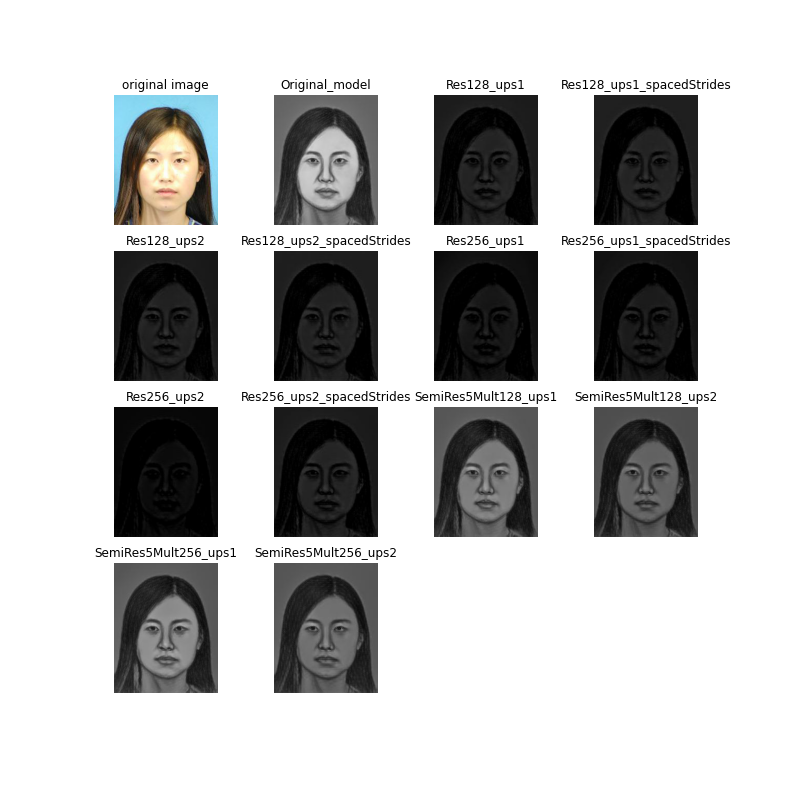

In [24]:
#This block saves the loaded sketches and displays it

os.chdir('/content/drive/My Drive/SketchSynthesisProject')
fig.savefig('face.png')
Image.open('face.png')

In [25]:
#This block downloads an image of a turtle which will be used to test
#how well the models generate a sketch from an unseen image

dirs_wild = '/content/drive/My Drive/SketchSynthesisProject/wild'
if not os.path.exists(dirs_wild):
    os.makedirs(dirs_wild)
os.chdir(dirs_wild)
!wget -q https://www.rhfleet.org/sites/default/files/turtle-odyssey_showpageheader.jpg

In [26]:
#This block generates a sketch from all the models on the unseen image

os.chdir('/content/drive/My Drive/SketchSynthesisProject/models (pretrained)')
test_dir = dirs_wild
for dirs in os.listdir()[1:-2]:
    sketch_save_path = os.path.join('resultWild', dirs)
    test_weight_path = os.path.join(dirs, 'G-26epochs.pth')
    if not os.path.exists(sketch_save_path):
        os.makedirs(sketch_save_path)
    if dirs == 'Original_model':
        dirs = 'networks.SketchNet'
    test(eval(dirs), test_weight_path, sketch_save_path)

Generating sketches using <class 'networks.SketchNet'>
Generating sketches using <class '__main__.Res128_ups1'>
Generating sketches using <class '__main__.Res128_ups1_spacedStrides'>
Generating sketches using <class '__main__.Res128_ups2'>
Generating sketches using <class '__main__.Res128_ups2_spacedStrides'>
Generating sketches using <class '__main__.Res256_ups1'>
Generating sketches using <class '__main__.Res256_ups1_spacedStrides'>
Generating sketches using <class '__main__.Res256_ups2'>
Generating sketches using <class '__main__.Res256_ups2_spacedStrides'>
Generating sketches using <class '__main__.SemiRes5Mult128_ups1'>
Generating sketches using <class '__main__.SemiRes5Mult128_ups2'>
Generating sketches using <class '__main__.SemiRes5Mult256_ups1'>
Generating sketches using <class '__main__.SemiRes5Mult256_ups2'>


In [27]:
#This block loads the generated sketch from all the models

os.chdir('/content/drive/My Drive/SketchSynthesisProject/models (pretrained)/resultWild')
fig = plt.figure(figsize=(11, 11))
img = mpimg.imread('/content/drive/My Drive/SketchSynthesisProject/wild/turtle-odyssey_showpageheader.jpg')
a = fig.add_subplot(4,4, 1)
imgplot = plt.imshow(img)
plt.axis('off')
a.set_title('Original image')
for k,i in enumerate(os.listdir()):
    img = mpimg.imread(i + '/turtle-odyssey_showpageheader.jpg')
    a = fig.add_subplot(4,4, k+2)
    imgplot = plt.imshow(img)
    plt.axis('off')
    a.set_title(i)

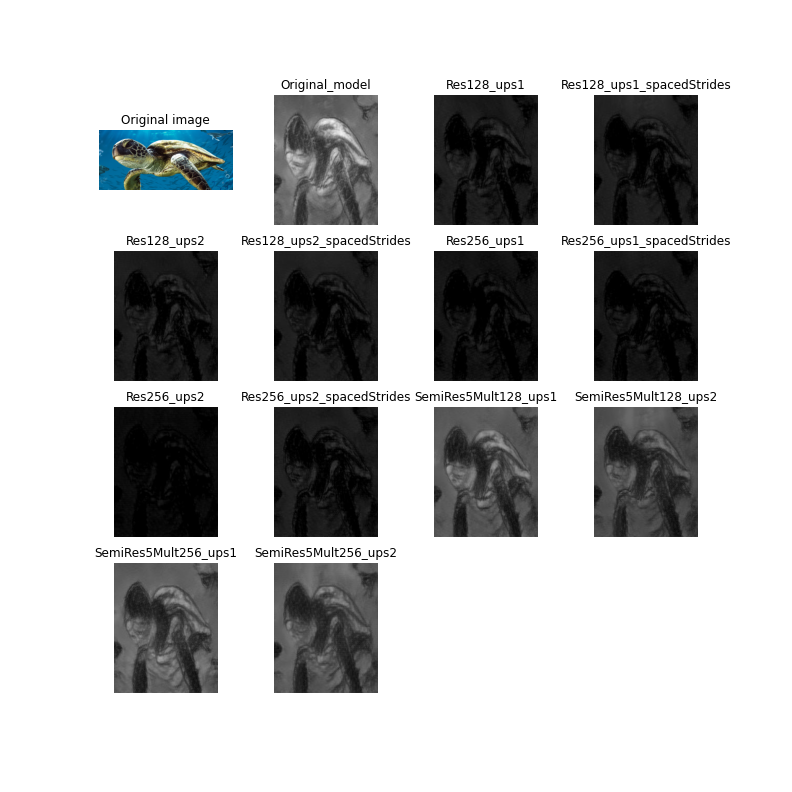

In [28]:
#This block saves the loaded sketches and displays it

os.chdir('/content/drive/My Drive/SketchSynthesisProject')
fig.savefig('wild.png')
Image.open('wild.png')

In [29]:
#The log.txt, which was saved from training all the models, is not suited
#for the pandas module, so this block fixes the log.txt file, such that
#it can be loaded with pandas such that graphs and statistics can be displayed

os.chdir('/content/drive/My Drive/SketchSynthesisProject/models (pretrained)')
df = {}
for folder in os.listdir()[1:-3]:
    with open(folder + '/log.txt', 'r+') as f:
        lines = f.readlines()
        lines.insert(0, 'CurrentTime, Epoch, Batch, totalBatch, DataLoadTime, TrainTime, Loss, Adv, tv, D\n')
        f.seek(0)
        for line in lines:
            line = line.replace('\t', ',\t')
            line = line.replace('\tEpoch ', '')
            line = line.replace('\tBatch [', '')
            line = line.replace('/786]', ',786')
            line = line.replace('\tData: ', '')
            line = line.replace('Train: ', ',')
            line = line.replace('\tLoss: G-', '')
            line = line.replace('Adv-', '')
            line = line.replace('tv-', '')
            line = line.replace('D-', '')
            f.write(line)
        f.truncate()
    
    df[folder] = pd.read_csv(folder + '/log.txt')
    df[folder].columns = df[folder].columns.str.replace(' ', '')

In [30]:
#This block loads the graphs as well as statistics from all the models

from pandas.plotting import table
fig = plt.figure(figsize=(20, 20))
for i,j in enumerate(df):
    a = fig.add_subplot(4,4, i+1)
    set_table = table(a, np.round(df[j].Loss.describe(), 2), loc='upper right', colWidths=[0.2, 0.2, 0.2])
    set_table.set_fontsize(13)
    set_table.scale(1.35, 1.35)
    df[j].plot(y='Loss', title=j, ax=a, legend=None)

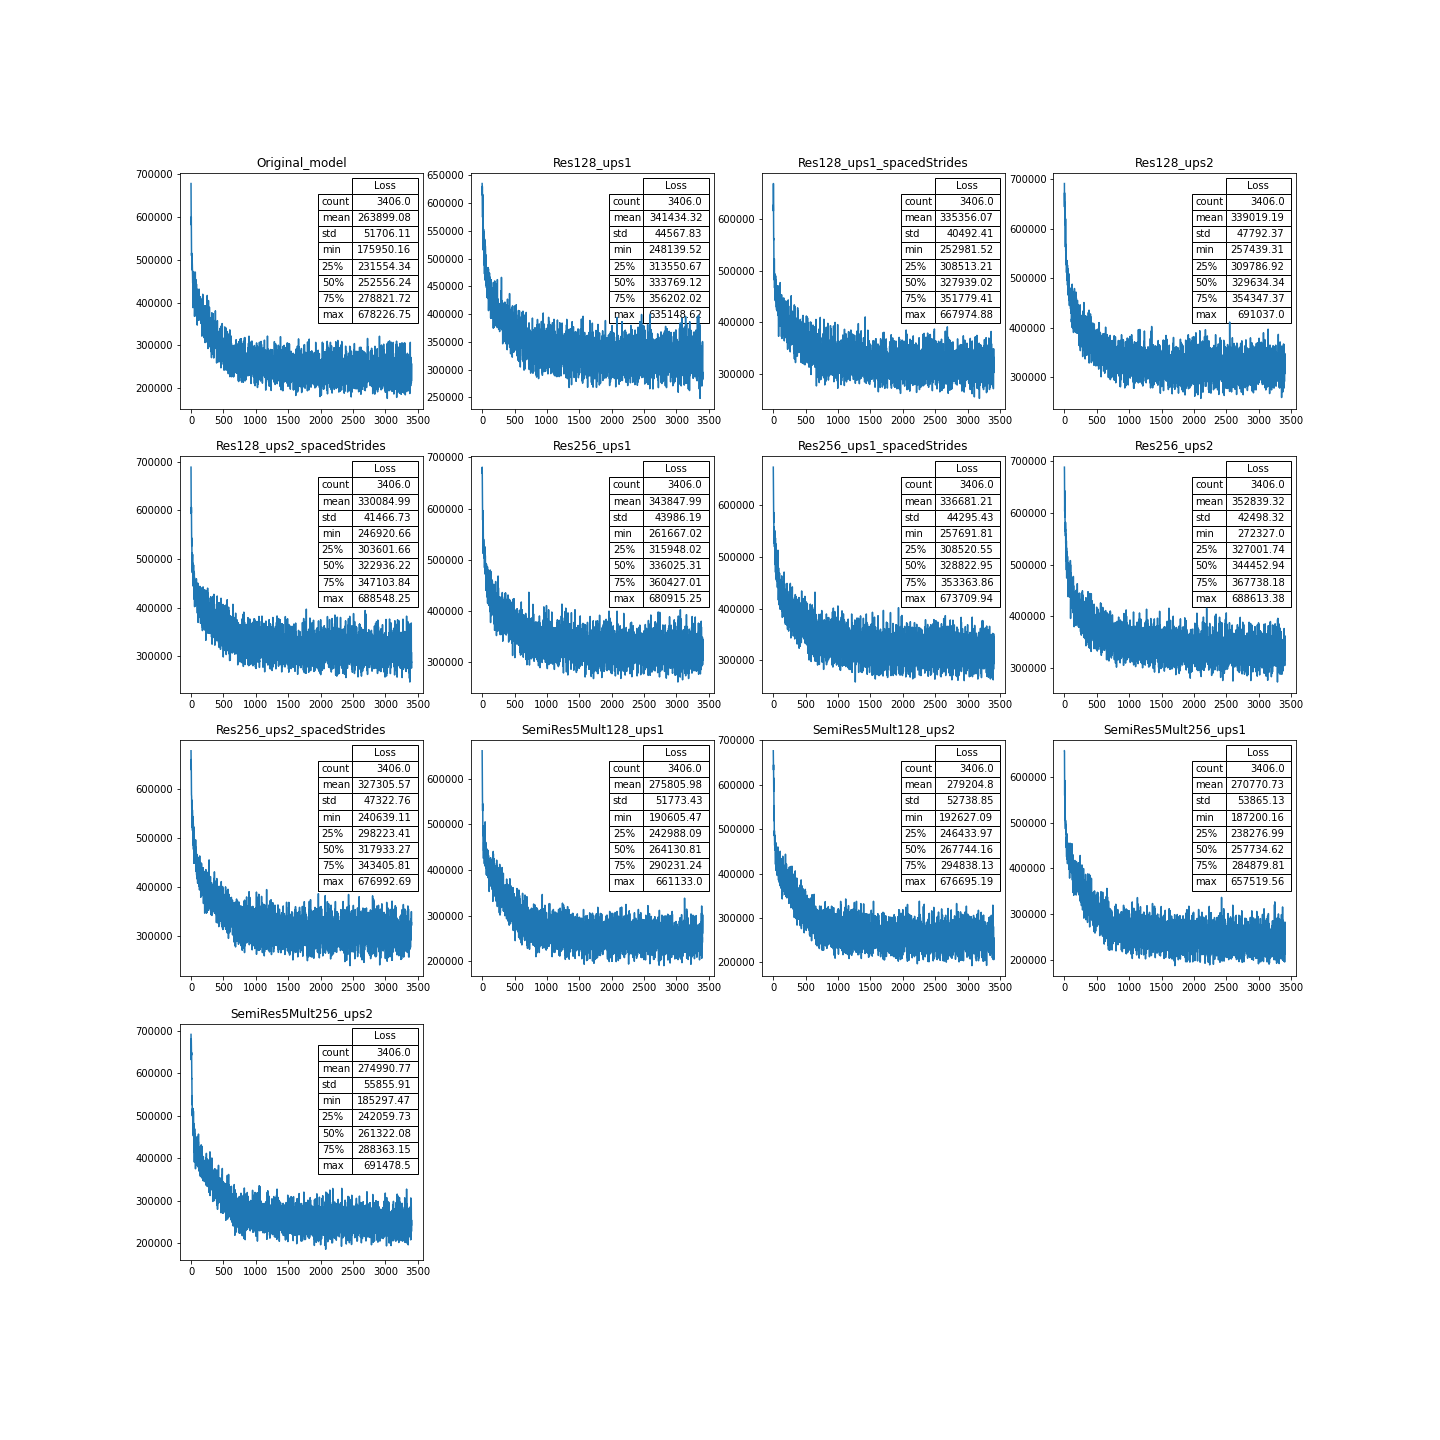

In [31]:
#This block saves the graphs and displays it

os.chdir('/content/drive/My Drive/SketchSynthesisProject')
fig.savefig('graphs.png')
Image.open('graphs.png')

In [2]:
#Run this to remove SketchSynthesisProject folder
import os
os.chdir('/content/drive/My Drive')
%rm -rf SketchSynthesisProject